# Bayesian Geolocation
## Danny Wolf & Taylor Sheneman - Report 4
### Computational Bayesian Statistics, Fall 2016

*You've just been abducted by aliens. (Yes, the conspiracy theorists are right.) After a bevy of horrific experiments, they set you back on Earth, right in the middle of...where? Could we figure out where in the world you were placed, based on some easily measurable local data?*

A plethora of data exist for conditions around the world, relating to both natural and manmade patterns. In this report, we seek to demonstrate how one might go about locating a person on the earth, using Bayesian methods, based on the answers to a few simple questions that could be relayed over, say, a phone call to a kidnapping hotline.

This report is one possible response to the above question, using the local area of one state (Massachusetts), one type of natural data, and one observation of manmade patterns. So, the more specific question is reframed as such:

*So, you've been set down somewhere in Massachusetts. Phew, not too far from school.*

* You notice that it's (raining/not raining).

*You walk for a while, and eventually*

* You come across a street, named (road name).

*Based on these two data points, where were you set down?*

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.style.use('ggplot')
import random

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeBinomialPmf, Beta, MakeMixture
import thinkplot

import scipy.stats as stats

from itertools import product
from operator import truediv

% matplotlib inline

import gdal
import gdalconst

In [2]:
class BilFile(object):

    def __init__(self, bil_file):
        self.bil_file = bil_file
        self.hdr_file = bil_file.split('.')[0]+'.hdr'

    def get_array(self, mask=None):
        self.nodatavalue, self.data = None, None
        gdal.GetDriverByName('EHdr').Register()
        img = gdal.Open(self.bil_file, gdalconst.GA_ReadOnly)
        band = img.GetRasterBand(1)
        self.nodatavalue = band.GetNoDataValue()
        self.ncol = img.RasterXSize
        self.nrow = img.RasterYSize
        geotransform = img.GetGeoTransform()
        self.originX = geotransform[0]
        self.originY = geotransform[3]
        self.pixelWidth = geotransform[1]
        self.pixelHeight = geotransform[5]
        self.data = band.ReadAsArray()
        return self.nodatavalue, self.data

Code adapted from http://gis.stackexchange.com/questions/97828/reading-zipped-esri-bil-files-with-python to process Band Interleaved by Line files, a rasterized image format commonly used to store and display various types of geographical and weather data.

In [3]:
def GetMonthlyPrismData():
    months = ['january','february','march','april','may','june','july','august','september','october','november','december']
    month_ns = ['01','02','03','04','05','06','07','08','09','10','11','12']
    res = dict()
    for i in range(12):
        f = BilFile(r'/alexandria/weather/prism-data/' + month_ns[i] + '-' + months[i] + '/PRISM_ppt_30yr_normal_800mM2_' + month_ns[i] + '_bil.bil')
        a = f.get_array()
        data = a[1].clip(0)
        res[months[i]] = pd.DataFrame(data)

    return pd.Panel(res)

Pulls the PRISM monthly normals datasets (http://prism.oregonstate.edu/normals/) from our locally stored copies and stores the result in a Pandas wide format panel.

In [4]:
class Geolocation(Suite, Joint):
    
    def __init__(self,xs,ys):
        """Makes a joint suite of location parameters x and y

        Enumerates all combinations of x, y

        xs: possible longitudinal (east-west) coordinates
        ys: possible latitudinal (north-south) coordinates
        """
        
        months = ['january','february','march','april','may','june','july','august','september','october','november','december']
        monthly_hours = [744,672,744,720,744,720,744,744,720,744,720,744]
        rain_data = GetMonthlyPrismData()
        #print('data retrieved')
        self.rain_percents = dict()
        for i,item in enumerate(rain_data.items):
            self.rain_percents[months[i]] = rain_data[months[i]] / (monthly_hours[i] * 3)
            #print(str(months[i]) + ' percentage calculated')
        
        locations = product(xs,ys) # (3105, 7025)
        Suite.__init__(self, locations)
    
    def Likelihood(self, data, hypo):
        """computes probability of data given hypo
        
        data: tuple of (data type, observation):
                ("road name", road name)
                ("rain", ({"raining","not raining"},month))
        
        hypo: x,y location in longitude,latitude
        """
        data_type, observation = data
        x, y = hypo
        
        if data_type == "rain":
            rain_state, month = observation
            if rain_state == "raining":
                like = self.rain_percents[month][x][y]
                
            elif rain_state == "not raining":
                like = 1 - self.rain_percents[month][x][y]
                
            else:
                raise ValueError("is it raining or not raining?")
                
            return like
        
        elif data_type == "road name":
            road_name = observation
            pmf = roadpmf()
            like = pmf.Prob(road_name)
            return like
        
        else:
            raise ValueError("Invalid data type")

Class for processing Bayesian updates based on weather and street data, updating a two-dimensional joint probability map over the area selected by the initialization conditions.

In [5]:
suite = Geolocation(range(6120,6720),range(840,1080))

/usr/lib/python2.7/dist-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


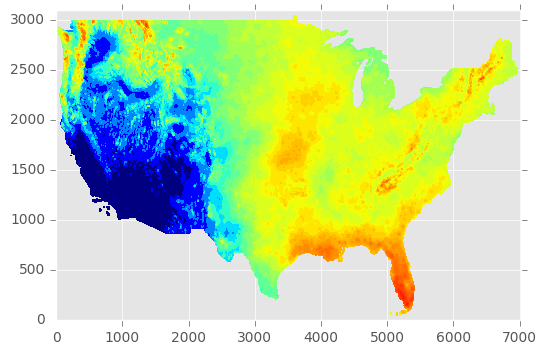

In [6]:
plt.contourf(suite.rain_percents['june'],origin='image',levels = np.linspace(0, .2, 40),cmap=plt.cm.jet,norm = LogNorm())

Initialization of the hypothesis suite based loosely around the bounds of Massachusetts, and an example of the PRISM weather data for the entire country (normals for January, from 1981-2010).

### Bayesian Updates

In the following section, we plot the results of several updates in succession, first of weather data then of roads. The final distribution represents our program's best guess at where you might be, based on the data given.

/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


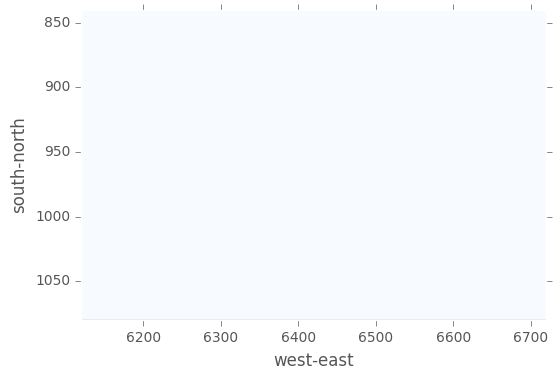

In [7]:
thinkplot.Contour(suite, contour=False, pcolor=True)
thinkplot.Config(xlabel='west-east',
                ylabel='south-north',
                axis=[6120, 6720, 1080, 840],
                origin='image')

In [8]:
suite.Update(("rain",("raining","june")))

0.033243134804665099

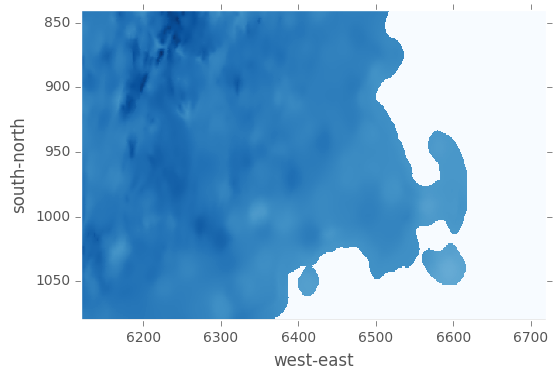

In [9]:
thinkplot.Contour(suite, contour=False, pcolor=True)
thinkplot.Config(xlabel='west-east',
                ylabel='south-north',
                axis=[6120, 6720, 1080, 840],
                origin='image')

In [10]:
suite.Update(("rain",("raining","june")))

0.049081774636565656

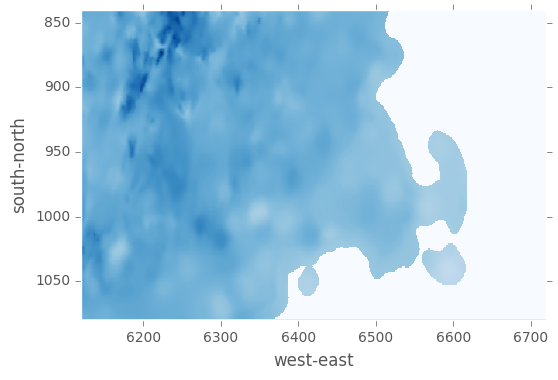

In [11]:
thinkplot.Contour(suite, contour=False, pcolor=True)
thinkplot.Config(xlabel='west-east',
                ylabel='south-north',
                axis=[6120, 6720, 1080, 840],
                origin='image')